#**MNIST Classification Task**

**시작 전 [런타임] > [런타임 유형 변경] > [하드웨어 가속기] > [GPU] 선택**

<a title="By Josef Steppan [CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0)], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:MnistExamples.png"><img width="512" alt="MnistExamples" src="https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"/></a>
[MNIST Examples]

In [ ]:
# Import required libraries

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import datasets, transforms
from torch.autograd import Variable


In [ ]:
# Variables

args = {}
kwargs = {}
args['batch_size'] = 1000 # Batch size
args['test_batch_size'] = 1000 # Test batch size
args['epochs'] = 10  # The number of epochs is the number of times you go through the full dataset.
args['lr'] = 0.01 # Learning rate is how fast it will decend.

args['seed'] = 1 # random seed
args['log_interval'] = 10 # log interval
args['cuda'] = True # GPU cuda enable


In [ ]:
# Load the MNIST data
# Train loader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

In [ ]:
# Test loader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

In [ ]:
# Network architecture

class Net(nn.Module):
    # Define the structure of CNN.

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)    # O = (32-5+0)/1 + 1 = 28  -> maxpool 14
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)   # O = (14-5+0)/1 + 1 = 10  -> maxpool 5 
        self.fc1 = nn.Linear(500, 50)   # 500 = 5*5*20
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # Convolution Layer > Activation Layer > Pooling Layer
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        # Convolution Layer > Activation Layer > Pooling Layer
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 500) # 500: fc 처리하기 직전 featuremap 개수 -> flatten

        # Fully Connected Layer > Activation Layer
        x = F.relu(self.fc1(x))

        # Fully Connected Layer > Activation Layer
        x = self.fc2(x)

        # Softmax gets probabilities.
        return F.log_softmax(x, dim=1)

#**Assignment 4-1**

**LeNet5 모델 구현하기**

*   아래 ***class LeNet*** 안에 LeNet-5 코드 구현하기.
*   다음 components들을 활용할 것: ***nn.Conv2d***, ***nn.Linear***, ***torch.tanh***, ***F.avg_pool_2d***, ***F.log_softmax***

\

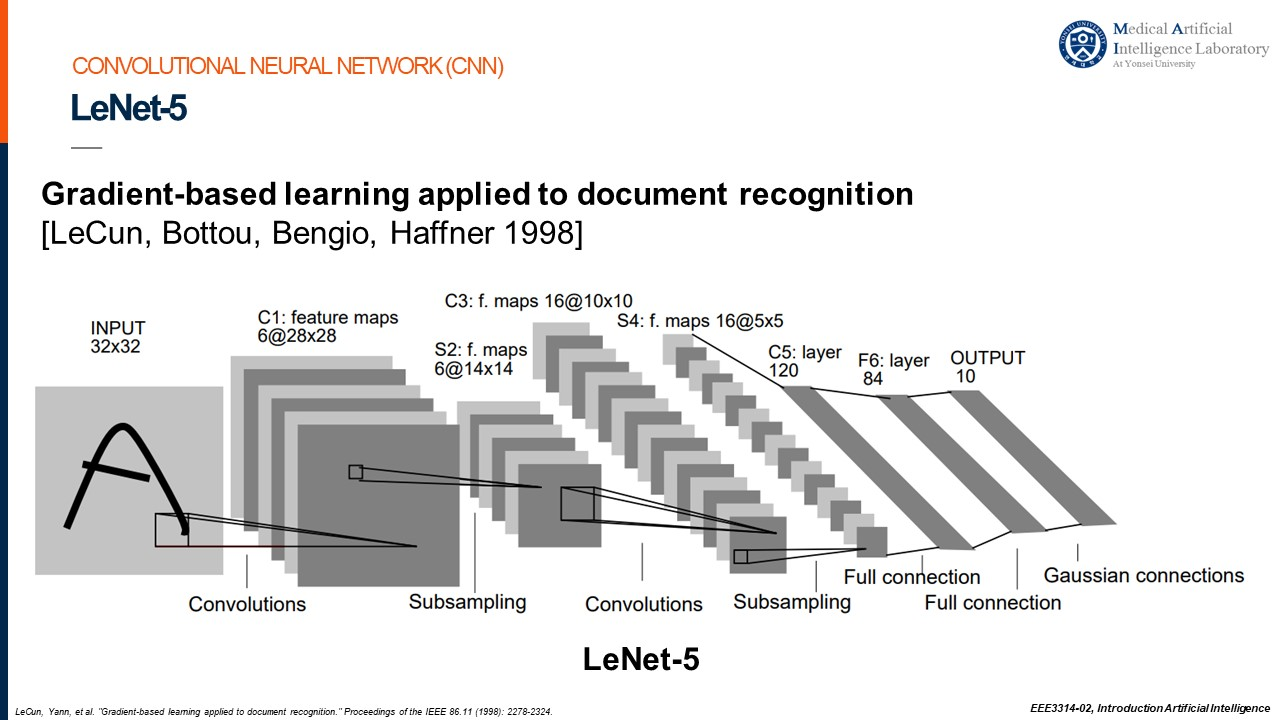


In [ ]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size = 5)      # O = (32-5+0)/1 + 1 = 28  -> avgpool 14
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5)     # O = (14-5+0)/1 + 1 = 10 -> avgpool 5
        self.conv3 = nn.Conv2d(16, 120, kernel_size = 5)   # O = (5-5+0)/1 + 1 = 1
        self.fc1 = nn.Linear(120, 84) # 120 = 1*1*120
        self.fc2 = nn.Linear(84, 10)  # output 10개 class (MNIST)

    def forward(self, x):
        x = F.avg_pool2d(torch.tanh(self.conv1(x)), 2) # Conv > Act > Pool
        x = F.avg_pool2d(torch.tanh(self.conv2(x)), 2) # Conv > Act > Pool
        x = torch.tanh(self.conv3(x)) # Conv > Act >
        x = x.view(-1, 120) # 120: fc 처리하기 직전 featuremap 개수 -> flatten
        x = torch.tanh(self.fc1(x)) # FC > Act
        x = self.fc2(x) # FC

        return F.log_softmax(x, dim=1) # Softmax prob


In [ ]:
# Classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


In [ ]:
# Definition of train

def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        # Cuda variable
        if args['cuda']:
            data, target = data.cuda(), target.cuda()

        # Pytorch variables
        data, target = Variable(data), Variable(target)

        # zero_grad() will zero out the gradients for this batch.
        optimizer.zero_grad()

        # The defined model generates the output.
        output = model(data)

        # Calculate the loss (negative log likelihood loss).
        loss = F.nll_loss(output, target)

        # Loss backpropagation
        loss.backward()

        # To do a one-step update on our parameter.
        optimizer.step()

        # Print out the logs periodically
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))


In [ ]:
# Definition of test

def test(print_class_accuracy):
    model.eval()

    # Initilize the variables
    test_loss = 0
    correct = 0
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # torch.no_grad() for test
    with torch.no_grad():
      for data, target in test_loader:
          # Cuda variable
          if args['cuda']:
              data, target = data.cuda(), target.cuda()

          # The trained model generates the output.
          output = model(data)

          # Calculates the test loss
          test_loss += F.nll_loss(output, target, reduction='sum').data # sum up batch loss

          # Get the index of the max log-probability
          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

          # Calculate the accuracy for each class
          for label, prediction in zip(target, pred):
            if label == prediction:
              correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

      test_loss /= len(test_loader.dataset)

      # Print out the logs periodically
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      # Print out the accuracy for each class
      if print_class_accuracy == True:
        for classname, correct_count in correct_pred.items():
          accuracy = 100 * float(correct_count) / total_pred[classname]
          print("Accuracy for class {:s}: {:d}/{:d} ({:.1f}%)".format(classname,correct_count,total_pred[classname],accuracy))


In [ ]:
# Select the model

model = Net()
#model = LeNet()
#model = MyNet()

In [ ]:
# GPU usage
if args['cuda']:
    model.cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test(print_class_accuracy=False)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307337
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.102563
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.482915
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.790592
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.506856
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.431874

Test set: Average loss: 0.3537, Accuracy: 8930/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.372718
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.323266
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.298519
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.293194
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.261310
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.243263

Test set: Average loss: 0.2268, Accuracy: 9325/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.226111
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.228895
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.198603
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.226972
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.192344
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.

In [ ]:
# Accuracy for each class
test(print_class_accuracy = True)


Test set: Average loss: 0.0536, Accuracy: 9821/10000 (98%)

Accuracy for class 0: 972/980 (99.2%)
Accuracy for class 1: 1123/1135 (98.9%)
Accuracy for class 2: 1008/1032 (97.7%)
Accuracy for class 3: 996/1010 (98.6%)
Accuracy for class 4: 965/982 (98.3%)
Accuracy for class 5: 880/892 (98.7%)
Accuracy for class 6: 944/958 (98.5%)
Accuracy for class 7: 988/1028 (96.1%)
Accuracy for class 8: 956/974 (98.2%)
Accuracy for class 9: 989/1009 (98.0%)


In [ ]:
# Test data shape
for data, target in test_loader:
  print(data.shape)

torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])
torch.Size([1000, 1, 32, 32])


In [ ]:
target[0:40]

tensor([9, 8, 1, 6, 9, 2, 5, 2, 5, 2, 9, 9, 2, 6, 6, 7, 7, 8, 2, 4, 7, 6, 4, 4,
        4, 5, 0, 1, 2, 8, 8, 1, 2, 8, 7, 8, 9, 0, 6, 3])

In [ ]:
# imshow function

def imshow(img):
    npimg = img.numpy() # tensor -> numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # channel transpose
    plt.show()

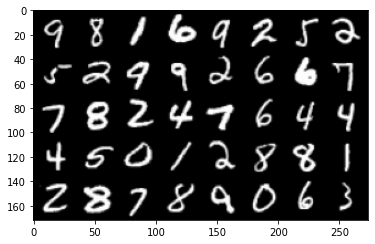

In [ ]:
imshow(torchvision.utils.make_grid(data[0:40,...]))

In [ ]:
output = model(data.cuda())
pred = output.data.max(1, keepdim=True)[1]

In [ ]:
torch.reshape(pred.cpu()[0:40],(5,8))

tensor([[9, 8, 1, 6, 9, 2, 5, 2],
        [5, 2, 9, 9, 2, 6, 6, 7],
        [7, 8, 2, 4, 7, 6, 4, 4],
        [4, 5, 0, 1, 2, 8, 8, 1],
        [2, 8, 7, 8, 9, 0, 6, 3]])

In [ ]:
torch.reshape(target[0:40],(5,8))

tensor([[9, 8, 1, 6, 9, 2, 5, 2],
        [5, 2, 9, 9, 2, 6, 6, 7],
        [7, 8, 2, 4, 7, 6, 4, 4],
        [4, 5, 0, 1, 2, 8, 8, 1],
        [2, 8, 7, 8, 9, 0, 6, 3]])

\


#**Assignment 4-2**



1.   직접 손으로 쓴 digit (0~9) load해서 이미지로 plot하기 (각 class당 10개 X 10개 class = 100개 digits)
  *   손으로 쓴 digits들을 10 X 10 grid 형태의 이미지로 plot 하기.
  *   가능하면 다른 글씨체, 스타일, 다른 필기도구 등으로 써서 성능을 파악하는 것이 목적.


2.   앞에서 학습시킨 MNIST Classification 모델에 테스트해서 Accuracy 수치 확인.
3.   위 2)번 Accuracy를 향상시키기 위한 본인만의 방법 제시 및 향상된 테스트 Accuracy 수치 제시
  *  예시) CNN 모델 수정, 영상 전처리(pre-processing) 추가 등
  *  추가하거나 수정한 코드 부분에는 주석으로 설명을 작성해야 함.


In [ ]:
# Google Drive mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


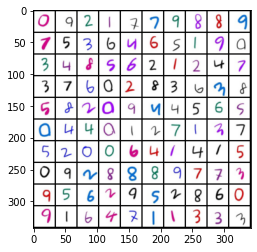

In [ ]:
### 1) Plot my written digits ###

# Original Test Dataset (MyDIgit data)
path = '/content/drive/MyDrive/MyMnist'
test_dataset = torchvision.datasets.ImageFolder(
    root = path,transform = transforms.Compose([
                       transforms.Resize((32, 32)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.,), (1.,))
                   ]))
# Test loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)
for data, target in test_loader:
  img = data # tensor

imshow(torchvision.utils.make_grid(img, nrow = 10))

In [ ]:
### 2) Print test accuracy with my written digits : Very low accuracy  ###

# Test Dataset for Real testing
path = '/content/drive/MyDrive/MyMnist'
test_dataset = torchvision.datasets.ImageFolder(
    root = path,transform = transforms.Compose([
                        transforms.Grayscale(num_output_channels=1), # 채널 수 변경(3->1)
                        transforms.Resize((32, 32)), # 이미지 사이즈 변경
                        transforms.ToTensor(), # tensor로 변경
                        transforms.Normalize((0.,), (1.,)) # 정규화
                   ]))

# Test loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)
for data, target in test_loader:
  img = data # tensor

# GPU usage
if args['cuda']:
    model.cuda()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test(print_class_accuracy=False)
# Accuracy for each class
test(print_class_accuracy = True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.053051
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.056157
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.063071
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.067092
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.047152
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.058176

Test set: Average loss: 10.4206, Accuracy: 9/100 (9%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.040491
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.053067
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.038358
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.058586
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.065134
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.061849

Test set: Average loss: 8.3596, Accuracy: 11/100 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.060058
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.032834
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.063580
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.040700
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.067752
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.048776

T

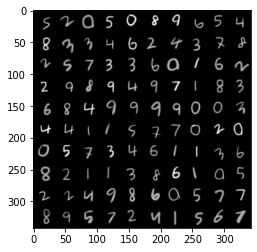

In [ ]:
### 3) Improve the test accuracy with my written digits ###

## (1) Pre-processing Test Dataset by transforms
path = '/content/drive/MyDrive/MyMnist'
test_dataset = torchvision.datasets.ImageFolder(
    root = path,transform = transforms.Compose([
                        transforms.Grayscale(num_output_channels=1), # 회색조 변경(1channel)
                        transforms.RandomInvert(p=1), # 흑백 반전 (Pre-processing) 
                        transforms.Resize((32, 32)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.,), (1.,))
                   ]))

# Test loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)
for data, target in test_loader:
  img = data # tensor

imshow(torchvision.utils.make_grid(img, nrow = 10))

In [ ]:
# GPU usage
if args['cuda']:
    model.cuda()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test(print_class_accuracy=False)
# Accuracy for each class
test(print_class_accuracy = True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.020306
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.048763
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.031876
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.016570
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.033089
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.029854

Test set: Average loss: 0.5972, Accuracy: 83/100 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.024167
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.022866
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.029979
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.034303
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.029858
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.043179

Test set: Average loss: 0.6536, Accuracy: 82/100 (82%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.036195
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.023688
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.024916
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.045520
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.023124
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.028542



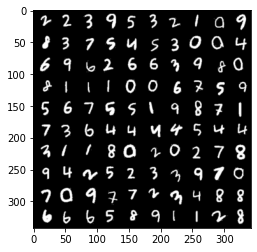

In [ ]:
## (2) Pre-processing Test Dataset by Invert class

# 좀 더 이미지의 대비를 높여 뚜렷하게 만들고자 invert라는 이름의 class를 정의하여
# thresh 값을 0~255 사이에서 조정하며 mnist data와 가장 비슷하게 processing을 진행함으로써
# 정확도를 높일 수 있는 최적의 thresh 값을 찾고자 함

import PIL.Image as Image

class Invert(torch.nn.Module):
    def __init__(self, thresh=255):
        super().__init__()
        self.thresh = thresh

    def forward(self, img):
        img = np.array(img) # torch tensor -> numpy array
        img[img < self.thresh] = 0 # min value
        img[img >= self.thresh] = 255 # max value
        img = Image.fromarray(img) # numpy array -> PIL image
        return torchvision.transforms.functional.invert(img) # invert image

path = '/content/drive/MyDrive/MyMnist'
test_dataset = torchvision.datasets.ImageFolder(
    root = path,transform = transforms.Compose([
                        transforms.Grayscale(num_output_channels=1),
                        Invert(thresh=245), # 위에서 정의한 Invert의 thresh 값 적절히 조정
                        transforms.Resize((32, 32)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.,), (1.,))
                   ]))

# Test loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args['test_batch_size'], shuffle=True, **kwargs)
for data, target in test_loader:
  img = data # tensor

imshow(torchvision.utils.make_grid(img, nrow = 10))

In [ ]:
# GPU usage
if args['cuda']:
    model.cuda()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test(print_class_accuracy=False)
# Accuracy for each class
test(print_class_accuracy = True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001535
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.004565
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.004034
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.002464
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.003238
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.002574

Test set: Average loss: 1.9557, Accuracy: 83/100 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.002060
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.000423
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.001131
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.003520
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.001440
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.006002

Test set: Average loss: 1.7545, Accuracy: 80/100 (80%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007242
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.004144
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.004981
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.005107
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.008004
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.001254



In [ ]:
## (3) Modifying CNN model

class MyNet(nn.Module):

    def __init__(self):
        super(MyNet, self).__init__()
        # input : 32 x 32
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, padding = 2) # 2 x 2 padding 추가
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, padding = 2) # 2 x 2 padding 추가
        self.fc1 = nn.Linear(64*8*8, 128) 
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution Layer > Activation Layer > Pooling Layer
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)

        # Convolution Layer > Activation Layer > Pooling Layer
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # flatten (vectorize)
        x = x.view(-1, 64*8*8)

        # Fully Connected Layer > Activation Layer
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training) # dropout 추가

        # Fully Connected Layer > Activation Layer
        x = self.fc2(x)

        # Softmax gets probabilities.
        return F.log_softmax(x, dim=1)


In [ ]:
model = MyNet()

In [ ]:
# GPU usage
if args['cuda']:
    model.cuda()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train & Test for defined epochs
for epoch in range(1, args['epochs'] + 1):
    train(epoch)
    test(print_class_accuracy=False)

# Accuracy for each class
test(print_class_accuracy = True)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.304501
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.110304
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.547734
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.421681
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.305739
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.290701

Test set: Average loss: 1.1384, Accuracy: 69/100 (69%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.219936
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.198486
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.206411
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.156022
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.151800
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.143460

Test set: Average loss: 0.8183, Accuracy: 80/100 (80%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.131939
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.127087
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.096290
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.092150
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.099480
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.117603



## 고찰
- 앞선 흑백 처리, 반전과 같은 Image Pre-Processing을 진행하여 약 70% 이상의 성능 향상을 가져올 수 있었음. (Best Accuracy = 85%, Average Accuracy = 약 83%)
- 정확도를 더 향상시켜 보고자 hidden layer를 추가하여 CNN model의 층을 깊게 해보았으나 오히려 정확도가 떨어지는 양상을 보임. 이를 통해 모델의 구조를 깊게 한다고 해서 항상 성능이 향상되는 것은 아님을 알게 됨.
- 각 layer의 channel 수를 늘려 봤으나 정확도 향상에 큰 도움이 되지 않았고, padding과 dropout도 효과가 없었음. (Best accuracy = 86% -> 1% 향상)
- 기존 MNIST dataset으로 test를 진행했을 때에도 초기 모델의 정확도가 약 98% 이상으로 높게 나왔었기에, 모델의 구조 변경으로는 정확도가 크게 향상되지 못하는 것이라는 결론을 내리게 됨.
- 이를 통해 이번 과제에서 사용한 dataset에 대해서는 모델의 구조를 변경하는 것보다는 이미지 전처리 과정이 정확도 향상에 있어 훨씬 큰 도움이 된다는 것을 깨달음.
- 이번 과제를 통해 직접 dataset을 만들어 test를 진행해보며 이미지 프로세싱(전처리)의 중요성을 느끼게 되었고 이를 위한 다양한 transform 방법이 존재한다는 것을 알게 됨.